In [98]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset
For this tutorial, we will use a IMDb dataset with plots and associated genres. We define our task as classifying the plots as those of action or romance movies based only on the plot text. 

The data is in `data/imdb/budgetandactors.txt`, which contains the plot and genre information about movies from the IMDb database. We pre-process the data below to generate the following:
* Featurize the plot text using bag-of-words representation
* Split the dataset into train, val, and test

**TODO: Featurize in loader and load in the words each feature represents**

In [99]:
dataset='trec'
from data.trec_loader import DataLoader
dl = DataLoader()
train_primitive_matrix, val_primitive_matrix, test_primitive_matrix,train_ground, val_ground, test_ground, vizer, val_idx, common_idx, _, _, _ = dl.load_data(dataset=dataset)

/home/ayusham/auto_lfs/reef/data/trec/all.txt
len of data 5965
4774 [    0     5     6 ... 36844 36855 36856]
common_idx 1094


In [100]:
train_primitive_matrix.shape

(4918, 1094)

In [101]:
# vizer.get_feature_names()[val_idx[common_idx[0]]]

x = [vizer.get_feature_names()[val_idx[i]] for i in common_idx ]
# x = vizer.get_feature_names()

# val_idx[100], common_idx[100]#, common_idx[val_idx[100]]

len(val_idx), len(common_idx)

len(test_ground), len(val_ground), len(train_ground)

(500, 547, 4918)

In [102]:
x[673]

'currency what'

In [34]:
len(np.where(val_ground==0)[0])

0

# Reef Steps
Reef generates heuristics in an iterative manner, with each iteration consisting of the following steps:
1. Synthesize Heuristics
2. Prune Heuristics
3. Verify Heuristics

In this tutorial, we go through the three stages of Reef individually and then repeat the process iteratively.

In the cell below, we run a single iteration by calling the `run_synthesizer` function. We pass in the primitive matrices for the `train` and `val` sets, along with ground truth labels for `val`. While we also pass in ground truth labels for `train`, this is solely for evaluation purposes. 

`max_cardinality` is the maximum number of primitives a heuristic takes as input, `keep` is how many heuristics the pruner should select (3 for the first iteration, 1 after that) and `model` is the type of heuristic to generate, in this case, `decision_tree`. 

_This cell does not output anything, only saves values in HeuristicGenerator._

In [337]:
from program_synthesis.heuristic_generator import HeuristicGenerator

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, test_primitive_matrix,
    test_ground, val_ground, train_ground, b=0.5)
hg.run_synthesizer(max_cardinality=1, idx=None, keep=90, model='dt')

self.b 0.16666666666666666


In [338]:
hg.L_val.shape

(1093, 90)

## 1. Synthesize Heuristics
We start by generating all possible heuristics based on the labeled, validation set that take in a single feature (i.e. word for this example) as input. 

For this example, we use decision trees with maximum depth 1 (`dt`) as our heuristic form. This translates to checking whether a certain word exists or does not exist in the text to assign a label. We first generate all possible heuristics that take a single feature in as input.

In [339]:
from program_synthesis.synthesizer import Synthesizer
syn = Synthesizer(val_primitive_matrix, val_ground, b=0.5)

heuristics, feature_inputs = syn.generate_heuristics('dt', 1)
# print ("Total Heuristics Generated: ", np.shape(heuristics)[1])

For each generated heuristic, we find an associated $\beta$ value.  This corresponds to defining a region of **low confidence** labels, which the heuristic will abstain for, while labeling the rest of the datapoints as $1$ or $-1$.

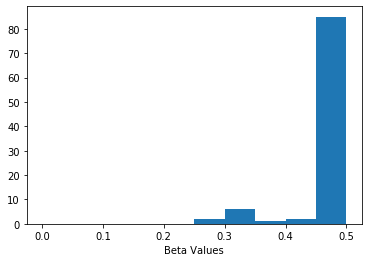

In [340]:
optimal_betas = syn.find_optimal_beta(heuristics[0], val_primitive_matrix, feature_inputs[0], val_ground)
plt.hist(optimal_betas, range=(0,0.5));
plt.xlabel('Beta Values');

## 2. Prune Heuristics
In the first iteration, we simply pick the 3 heuristics that perform the best on the labeled validation set. 

In [344]:
top_idx = hg.prune_heuristics(heuristics, feature_inputs, keep=10)
print ('Features chosen heuristics are based on: ', top_idx)

AttributeError: 'NoneType' object has no attribute 'L_train'

In [327]:
[x[i] for i in top_idx]

['who found',
 'how would',
 'who build',
 'what is',
 'made by',
 'made using',
 'when was',
 'who owns',
 'how should',
 'why can']

In [330]:
f1_score(hg.val_ground, hg.L_val[:,1], average='weighted')

0.09108200510425193

In [324]:
from sklearn.metrics import f1_score
[f1_score(hg.val_ground, hg.L_val[:,i], average='weighted') for i in range(np.shape(hg.L_val)[1])]

[0.15326388497114224,
 0.09108200510425193,
 0.08296232778388146,
 0.0777676120768527,
 0.050376369479556475,
 0.03695156422826398,
 0.03674513865345229,
 0.034245244111135865,
 0.03202916195402382,
 0.026969654631578473,
 0.023833258228527988,
 0.02108458787324295,
 0.020718354336983148,
 0.019238895196522596,
 0.017548332908373702,
 0.017489904724111452,
 0.017447179727228236,
 0.017108874656907594,
 0.015887196598676066,
 0.01571223182777228,
 0.015649563015270457,
 0.015632474305803893,
 0.014154688362456806,
 0.014154688362456806,
 0.014038051000539564,
 0.010717553261011632,
 0.01070448307410796,
 0.010134421845309311,
 0.008890680809051954,
 0.00877378187533723,
 0.007202195791399817,
 0.0071983244236425645,
 0.007196291142257453,
 0.00716602079870475,
 0.00716602079870475,
 0.007106710754594496,
 0.005423340204367332,
 0.005402802523233977,
 0.005402802523233977,
 0.005402802523233977,
 0.005402802523233977,
 0.005401646843549863,
 0.0053953731538361,
 0.005380126338197074,
 0.

In [284]:
hg.heuristic_stats()

,Feat 1,Feat 2,Feat 3,Val Acc,Train Acc,Val Cov,Train Cov
0,56.0,-1.0,-1.0,0.000000,0.000229,1.00000,1.00000
1,5.0,-1.0,-1.0,0.018298,0.019671,1.00000,1.00000
2,60.0,-1.0,-1.0,0.057640,0.047575,1.00000,1.00000
3,9.0,-1.0,-1.0,0.000000,0.000000,0.94968,0.94236
4,45.0,-1.0,-1.0,0.000000,0.000000,1.00000,1.00000
...,...,...,...,...,...,...,...
85,84.0,-1.0,-1.0,0.000000,0.000000,1.00000,1.00000
86,19.0,-1.0,-1.0,0.000000,0.000000,1.00000,1.00000
87,11.0,-1.0,-1.0,0.000000,0.000000,1.00000,1.00000
88,12.0,-1.0,-1.0,0.000000,0.000000,1.00000,1.00000


In [244]:
feats = set(hg.heuristic_stats().sort_values('Val Cov', ascending=False)['Feat 1'])
feats2 = set(hg.heuristic_stats().sort_values('Val Cov', ascending=False)['Feat 2'])

[Text(167.4, 163.07999999999998, 'X[56] <= 0.5\nentropy = 0.791\nsamples = 500\nvalue = [76, 63, 124, 115, 118, 4]'),
 Text(83.7, 54.360000000000014, 'entropy = 0.788\nsamples = 435\nvalue = [75, 63, 62, 114, 117, 4]'),
 Text(251.10000000000002, 54.360000000000014, 'entropy = 0.089\nsamples = 65\nvalue = [1, 0, 62, 1, 1, 0]')]

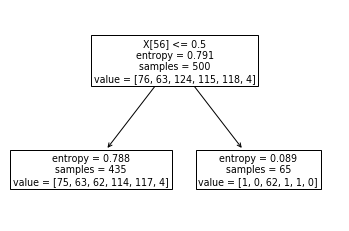

In [245]:
from sklearn import tree
clf = hg.hf[2].fit(test_primitive_matrix, test_ground)
tree.plot_tree(clf)

In [267]:
for i in (hg.heuristic_stats()['Feat 1']):#, hg.heuristic_stats()['Feat 2']):#, hg.heuristic_stats()['Feat 3']):
    print(x[int(i)])#, x[int(j)])#, x[int(k)])

who found
how would
who build
what is
made by
made using
when was
who owns
how should
why can


In subsequent iterations (step 4), we weight the Jaccard score (overlap of how many datapoints in the train set receive labels and how many are labeled by existing heuristics) and F1 score equally. We demonstrate this with a toy vector of previously labeled data.

## 3. Verify Heuristics
In this step, we use the labels the heuristics assign to the **unlabeled train set** to estimate heuristic accuracies and assign probabilistic training labels to the same set accordingly (see [snorkel.stanford.edu](http://snorkel.stanford.edu) for more details). 

In [155]:
from program_synthesis.verifier import Verifier
verifier = Verifier(hg.L_train, hg.L_val, val_ground, has_snorkel=False)

verifier.train_gen_model()
verifier.assign_marginals()

We visualize what these labels look like. Note that with a single iteration, none of the datapoints receive a probabilistic label greater than 0.5, but this is fixed after running the process iteratively (Step 4). __These labels are then used to train an end model, such as an LSTM, and not used as final predictions.__ 

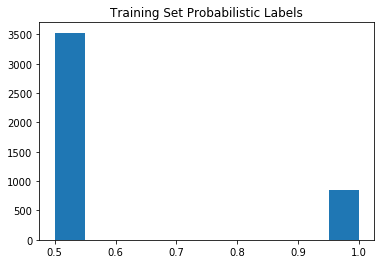

In [156]:
plt.hist(verifier.train_marginals); plt.title('Training Set Probabilistic Labels');

Since we do not have access to ground truth labels for the train set, we use the distribution of labels for the labeled validation set to decide what feedback to pass to the synthesizer. We pass datapoints with low confidence (labels near 0.5, i.e. equal probability of being +1 or -1) to the synthesizer

Percentage of Low Confidence Points:  0.8133577310155535


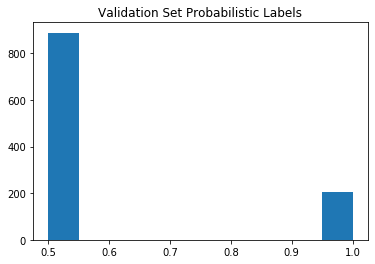

In [157]:
plt.hist(verifier.val_marginals); plt.title('Validation Set Probabilistic Labels');
feedback_idx = verifier.find_vague_points(gamma=0.1,b=0.5)
print ('Percentage of Low Confidence Points: ', np.shape(feedback_idx)[0]/float(np.shape(val_ground)[0]))

## 4. Repeat Iterative Process of Generating Heuristics
We repeat this process of synthesizing, pruning, and verifying heuristics iteratively. In this example, we generate 25 total heuristics. 

_Note that this process wil take a few minutes to run since heuristic generation is not currently optimized in any manner_

In [103]:
from program_synthesis.synthesizer import Synthesizer
from program_synthesis.heuristic_generator import HeuristicGenerator
training_marginals = []
vals=[]
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []
for j in range(0,1):
    print('j',j)
    validation_accuracy = []
    training_accuracy = []
    validation_coverage = []
    training_coverage = []

    idx = None

    if j == 0:
        # print('value of j',j)
        hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, test_primitive_matrix,
                        test_ground, val_ground, train_ground, 
                        b=0.5)


    for i in range(3,21):
        if (i-2)%5 == 0:
            print ("Running iteration: ", str(i-2))

        #Repeat synthesize-prune-verify at each iterations
        if i == 3:
            hg.run_synthesizer(max_cardinality= 1, idx=idx, keep= 3, model='dt')
        else:
            hg.run_synthesizer(max_cardinality= 1, idx=idx, keep= 1, model='dt')
        hg.run_verifier()

        #Save evaluation metrics
        val_lfs, train_lfs = [], []
        va,ta, vc, tc, val_lfs, train_lfs, test_lfs = hg.evaluate()
        validation_accuracy.append(va)
        training_accuracy.append(ta)
        training_marginals.append(hg.vf.train_marginals)
        validation_coverage.append(vc)
        training_coverage.append(tc)
#         print('shape is ', val_lfs.shape, train_lfs.shape)

        if i==15 and j==0:
    #         print('inside me ', labs[0])
#             np.save(os.path.join(save_path ,val_file_name), val_lfs)
#             np.save(os.path.join(save_path ,train_file_name), train_lfs)
#             np.save(os.path.join(save_path ,test_file_name), test_lfs)
            print('labels saved') 
     

        #Find low confidence datapoints in the labeled set
        hg.find_feedback()
        idx = hg.feedback_idx
#         if i %3 ==0:
        print(len(idx))

        #Stop the iterative process when no low confidence labels

        # if mode == 'normal' or mode == 'random':
        if idx == [] and j==0:
#             np.save(os.path.join(save_path ,val_file_name), val_lfs)
#             np.save(os.path.join(save_path ,train_file_name), train_lfs)
#             np.save(os.path.join(save_path ,test_file_name), test_lfs)
            print('index exhausted, labels saved')
            break
    vals.append(validation_accuracy[-1])
    print ("Program Synthesis Train Accuracy: ", training_accuracy[-1])
    print ("Program Synthesis Train Coverage: ", training_coverage[-1])
    print ("Program Synthesis Validation Accuracy: ", validation_accuracy[-1])

j 0
self.b 0.16666666666666666
68
482
343
352
Running iteration:  5
329
329
329
329
329
Running iteration:  10
329
329
329
labels saved
329
329
Running iteration:  15
329
329
329
329
Program Synthesis Train Accuracy:  0.21634810898739326
Program Synthesis Train Coverage:  1.0
Program Synthesis Validation Accuracy:  0.1882998171846435


In the plots above, we show the distribution of probabilistic labels Reef assigns to the training set in the first few iterations.

Next, we look at the accuracy and coverage of labels assigned to the training set in the _last_ iteration. The coverage is the percentage of training set datapoints that receive at least one label from the generated heuristics.

In [104]:
valx = val_lfs

yoyo = list(range(1,6))
yoyo.append(-1)
labels_lfs = []
idxs = []
for i in range(valx.shape[1]):
    for j in yoyo:
        if len(np.where(valx.T[i]==j)[0]) > 1:
            labels_lfs.append(j)
            idxs.append(i)
            break;

In [105]:
labels_lfs

[2, 3, -1, -1, 1, 3, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [95]:
idxs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [119]:
len(idx)

329

In [117]:
for i in hg.heuristic_stats().iloc[:len(idx)]['Feat 1']:
    print(x[int(i)])

who
what is
how
how long
where
why
where
how many
how many
how many
how many
how many
how many
how many
how many
how many
how many
how many
how many
how many


In [114]:
feats = set(hg.heuristic_stats().sort_values('Val Cov', ascending=False)['Feat 1'])
feats

{244.0, 292.0, 315.0, 347.0, 1022.0, 1032.0, 1033.0}

In [120]:
hg.heuristic_stats().sort_values('Val Cov', ascending=False)

,Feat 1,Feat 2,Feat 3,Val Acc,Train Acc,Val Cov,Train Cov
3,1032.0,-1.0,-1.0,0.153565,0.171614,1.000000,1.000000
1,244.0,-1.0,-1.0,0.146252,0.166938,0.210238,0.196421
2,1022.0,-1.0,-1.0,0.153565,0.171614,0.124314,0.140911
0,315.0,-1.0,-1.0,0.153565,0.171614,0.118830,0.104717
4,292.0,-1.0,-1.0,0.195612,0.220821,0.043876,0.055510
6,292.0,-1.0,-1.0,0.195612,0.220821,0.043876,0.055510
13,1033.0,-1.0,-1.0,0.153565,0.171614,0.042048,0.057747
18,1033.0,-1.0,-1.0,0.153565,0.171614,0.042048,0.057747
17,1033.0,-1.0,-1.0,0.153565,0.171614,0.042048,0.057747
16,1033.0,-1.0,-1.0,0.153565,0.171614,0.042048,0.057747


In [122]:
# for i,j in zip(hg.heuristic_stats().iloc[0:len(idxs)]['Feat 1'], hg.heuristic_stats().iloc[0:len(idxs)]['Feat 2']):#, hg.heuristic_stats()['Feat 3']):
#     print(x[int(i)], x[int(j)])#, x[int(k)])
for i in hg.heuristic_stats().iloc[:len(idxs)]['Feat 1']:
    print(i, (x[int(i)]))
    


315.0 who
244.0 what is
1022.0 how
1032.0 how long
292.0 where
347.0 why
292.0 where
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many
1033.0 how many


In [116]:
feats

{244.0, 292.0, 315.0, 347.0, 1022.0, 1032.0, 1033.0}

In [74]:
hffeats = set(hg.heuristic_stats().sort_values('Val Cov', ascending=False)['Feat 1'])

[Text(167.4, 163.07999999999998, 'X[315] <= 0.5\ngini = 0.791\nsamples = 500\nvalue = [76, 63, 124, 115, 118, 4]'),
 Text(83.7, 54.360000000000014, 'gini = 0.788\nsamples = 435\nvalue = [75, 63, 62, 114, 117, 4]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.089\nsamples = 65\nvalue = [1, 0, 62, 1, 1, 0]')]

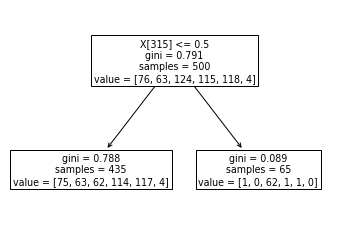

In [109]:
feats = set(hg.heuristic_stats().sort_values('Val Cov', ascending=False)['Feat 1'])
feats2 = set(hg.heuristic_stats().sort_values('Val Cov', ascending=False)['Feat 2'])

from sklearn import tree
clf = hg.hf[2].fit(test_primitive_matrix, test_ground)
tree.plot_tree(clf)

In [110]:
for i in feats:
    print(x[int(i)])
print('-------------')

for j in feats2:
    print(x[int(j)])

where
how long
how many
why
what is
who
how
-------------
to ?


Program Synthesis Train Accuracy:  0.4670714619336759
Program Synthesis Train Coverage:  0.48970722781335774
Program Synthesis Validation Accuracy:  0.4843462246777164


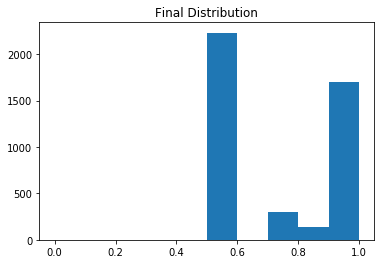

In [56]:
plt.hist(training_marginals[-1], bins=10, range=(0.0,1.0)); 
plt.title('Final Distribution');

print ("Program Synthesis Train Accuracy: ", training_accuracy[-1])
print ("Program Synthesis Train Coverage: ", training_coverage[-1])
print ("Program Synthesis Validation Accuracy: ", validation_accuracy[-1])


### Save Training Set Labels 
We save the training set labels Reef generates that we use in the next notebook to train a simple LSTM model.

In [ ]:
filepath = './data/' + dataset
np.save(filepath+'_reef.npy', training_marginals[-1])